# 1 - install dependencies

In [1]:
import numpy as np
import cv2 
import os
import mediapipe as mp
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pandas as pd
from tensorflow.keras.utils import to_categorical

In [2]:
# set gpu to use memory only when needed
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2021-12-29 14:33:12.225265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 14:33:12.229294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 14:33:12.229562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 14:33:12.230518: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 2- read and process data

In [2]:
data_path = os.path.join("..",'..','..','data','Datasets')

train_labels = pd.read_csv(os.path.join(data_path,"train_labels.csv"),names=['sample','id'])
validation_labels = pd.read_csv(os.path.join(data_path,"validation_labels.csv"),names=['sample','id'])
test_labels = pd.read_csv(os.path.join(data_path,"test_labels.csv"),names=['sample','id'])
class_id = pd.read_csv(os.path.join(data_path,"class_id.csv"))


    
train_path = os.path.join(data_path,"train")
val_path = os.path.join(data_path,"val")
test_path = os.path.join(data_path,"test")

n_actions = 5
actions = list(class_id['EN'][:n_actions])
dic={}
for i,action in enumerate(actions):
    dic[action]=i


In [3]:
def check_file(file_path):
    try:
        f = open(file_path)
        f.close()
        return True
    except IOError:
        return False
    
    

def construct_path(file,path="train"):
    return os.path.join(os.path.join(data_path,path),file+"_color.mp4")



def get_data(id,file_path):
    if file_path=="train":
        label_dic = train_labels
    elif file_path=="val":
        label_dic = validation_labels
    elif file_path=="test":
        label_dic = test_labels
        
    
    data =  label_dic[label_dic['id']==id]
    lis =  [construct_path(i,file_path) for i in  (data['sample'])]
    data =  [i for i in lis if check_file(i)]
    return data,[id for i in data]
    

### 3.1 collect data that in classes {0,1,2,3,4} from Train & validation & test

In [4]:


train_X = [] 
train_Y = []
val_X = [] 
val_Y = []
test_X = [] 
test_Y = []

for i in range(n_actions):
    data,labels = get_data(i,'train')
    train_X.extend(data)
    train_Y.extend(labels)

    
for i in range(n_actions):
    data,labels = get_data(i,'val')
    val_X.extend(data)
    val_Y.extend(labels)

    
for i in range(n_actions):
    data,labels = get_data(i,'test')
    test_X.extend(data)
    test_Y.extend(labels)


    
train_X = np.array(train_X)
val_X = np.array(val_X)
test_X = np.array(test_X)
train_Y = np.array(train_Y)
val_Y = np.array(val_Y)
test_Y = np.array(test_Y)
    


perm = np.random.permutation(len(train_X))
train_X = train_X[perm]
train_Y = train_Y[perm]



In [5]:
print(
    len(train_X ),
len(train_Y),
len(val_X ),
len(val_Y),
len(test_X ),
len(test_Y)
)


622 622 98 98 83 83


### 3.2 process videos into frames and label to cateogries

In [145]:
def capture_frames(video_path):
    video = cv2.VideoCapture(video_path)
    video_length = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    # count = 0
    # frame_rate = video.get(cv2.CAP_PROP_FRAME_COUNT)

    count=0
    frames = []
    while video.isOpened():
      # frame_id = video.get(0)
        ret, frame = video.read()
        
        if not ret:
            continue
        frames.append(frame)
        count += 1
        # If there are no more frames left
        if (count > (video_length-1)):
          # Release the feed
          video.release()
        # if frame_id % math.floor(1) == 0:
        #     file_name = f"{video_path}_frame_{count}.jpg"
        #     count += 1
        #     # print(f"File name: {file_name}")
        #     frames.append(frame)
        #     # cv2.imwrite(file_name, frame)
    video.release()
    return np.array(frames)


def get_frames(video_path,num_frames,scale=True):
    frames = capture_frames(video_path)
    video_length = len(frames)
    steps = video_length/num_frames
    count=0
    new_frames=[]
    while count<video_length:
        frame = frames[int(count)]
        frame = cv2.resize(frame, (256, 256))
        if scale:
            frame =  (frame/255.0).astype(np.float16)
        new_frames.append(frame)
        count+=steps

    s = np.array(new_frames[:num_frames])
    return np.array(new_frames[:num_frames])


In [8]:
# train_data = [] 
# for i,video in enumerate(train_X):
#     print(f' train step : {i+1}/{len(train_X)}',end="\r")
#     train_data.append(get_frames(video,15))
    
    
# val_data = [] 
# for i,video in enumerate(val_X):
#     print(f' Val step : {i+1}/{len(val_X)}',end="\r")
#     val_data.append(get_frames(video,15))
    
    
# test_data = [] 
# for i,video in enumerate(test_X):
#     print(f' Test step : {i+1}/{len(test_X)}',end="\r")
#     test_data.append(get_frames(video,15))
    
    
    
# train_X = np.array(train_data)
# val_X = np.array(val_data)
# test_X = np.array(test_data)
# train_Y = np.array(train_Y)
# val_Y = np.array(val_Y)
# test_Y = np.array(test_Y)

# del train_data
# del val_data
# del test_data


In [87]:
print(
train_X.shape,
    train_Y.shape,
    val_X.shape,
    val_Y.shape,
    test_X.shape,
    test_Y.shape
    
)

(622,) (622,) (98,) (98,) (83,) (83,)


# 4 - build the model

In [146]:
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, batch_size=32,data=None,labels=None,n_frames=15 ):
        self.batch_size = batch_size
        self.data = data
        self.labels = labels
        self.n_frames = n_frames
        
    

    def __len__(self):
        # returns the number of batches
        ...
        return len(self.data) // self.batch_size

    def __getitem__(self, index):
        # returns one batch
        new_ind = index*self.batch_size
        X = self.data[new_ind:new_ind+self.batch_size]
        X = np.array([get_frames(video,self.n_frames) for video in X])
        y = self.labels[new_ind:new_ind+self.batch_size]
        # y = np.zeros(len(y))
        return X, y

    def on_epoch_end(self):
        perm = np.random.permutation(len(self.data))
        self.data = self.data[perm]
        self.labels = self.labels[perm]
        pass

In [56]:
train_ds = CustomDataset(batch_size=2,data=train_X,labels=train_Y,n_frames=15)
val_ds = CustomDataset(batch_size=2,data=val_X,labels=val_Y,n_frames=15)


In [152]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import optimizers
from tensorflow import keras


video = Input(shape=(15, 256, 256, 3))

cnn_base = VGG16(input_shape=(256, 256, 3), weights="imagenet", include_top=False)

cnn_out = GlobalAveragePooling2D()(cnn_base.output)
cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
cnn.trainable = False
encoded_frames = TimeDistributed(cnn)(video)
encoded_sequence = LSTM(256)(encoded_frames)
hidden_layer = Dense(units=1024, activation="relu")(encoded_sequence)
outputs = Dense(units=5, activation="softmax")(hidden_layer)
model = Model([video], outputs)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 15, 256, 256, 3)  0         
                             ]                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 512)          14714688  
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 256)               787456    
                                                                 
 dense_4 (Dense)             (None, 1024)              263168    
                                                                 
 dense_5 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 15,770,437
Trainable params: 15,770,437
Non-t

In [153]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002,
                             beta_1=0.9,
                             beta_2=0.999, 
                             epsilon=1e-08,
                             schedule_decay=0.004)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [154]:
history = model.fit(train_ds,validation_data=val_ds,epochs=4)

Epoch 1/4


2021-12-29 15:33:53.445134: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-29 15:33:53.445539: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 585.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-29 15:34:03.445884: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 120.00MiB (rounded to 125829120)requested by op model_5/time_distributed_2/model_4/block3_conv3/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current alloc

ResourceExhaustedError:  OOM when allocating tensor with shape[30,256,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_5/time_distributed_2/model_4/block3_conv3/Relu
 (defined at /home/mina/.local/lib/python3.8/site-packages/keras/backend.py:4867)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_27838]

Errors may have originated from an input operation.
Input Source operations connected to node model_5/time_distributed_2/model_4/block3_conv3/Relu:
In[0] model_5/time_distributed_2/model_4/block3_conv3/BiasAdd (defined at /home/mina/.local/lib/python3.8/site-packages/keras/layers/convolutional.py:264)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_103805/1134393417.py", line 1, in <module>
>>>     history = model.fit(train_ds,validation_data=val_ds,epochs=4)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/layers/wrappers.py", line 267, in call
>>>     y = self.layer(inputs, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/layers/convolutional.py", line 273, in call
>>>     return self.activation(outputs)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/activations.py", line 311, in relu
>>>     return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
>>> 
>>>   File "/home/mina/.local/lib/python3.8/site-packages/keras/backend.py", line 4867, in relu
>>>     x = tf.nn.relu(x)
>>> 

In [62]:
model.save_weights('weights.h5')

In [147]:
data,labels = train_ds.__getitem__(1)
print(labels)

[1 1]


In [150]:
for i in range(15):
    video = data[0][i]
    video = (video*255).astype(np.uint8)
    print(video.shape)
    cv2.imshow("frame",video)
    cv2.waitKey(250)
cv2.destroyWindow('frame')

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


In [138]:
data1 = get_frames(train_X[0],15,scale=True)
data2 = get_frames(train_X[0],15,scale=False)


In [142]:
data2

array([[[[129, 145, 145],
         [129, 145, 145],
         [129, 145, 145],
         ...,
         [104, 121, 119],
         [104, 121, 119],
         [104, 121, 119]],

        [[129, 145, 145],
         [129, 145, 145],
         [129, 145, 145],
         ...,
         [104, 121, 119],
         [104, 121, 119],
         [104, 121, 119]],

        [[129, 145, 145],
         [129, 145, 145],
         [129, 145, 145],
         ...,
         [104, 121, 119],
         [104, 121, 119],
         [104, 121, 119]],

        ...,

        [[ 17,  55,  77],
         [ 17,  55,  77],
         [ 17,  55,  77],
         ...,
         [ 13,  49,  64],
         [ 13,  49,  64],
         [ 13,  49,  64]],

        [[ 15,  55,  78],
         [ 15,  55,  78],
         [ 15,  55,  78],
         ...,
         [ 17,  48,  64],
         [ 17,  48,  64],
         [ 17,  48,  64]],

        [[ 15,  55,  78],
         [ 15,  55,  78],
         [ 15,  55,  78],
         ...,
         [ 21,  47,  64],
        

In [144]:
(data1*255).astype(np.uint8)

array([[[[129, 145, 145],
         [129, 145, 145],
         [129, 145, 145],
         ...,
         [104, 121, 119],
         [104, 121, 119],
         [104, 121, 119]],

        [[129, 145, 145],
         [129, 145, 145],
         [129, 145, 145],
         ...,
         [104, 121, 119],
         [104, 121, 119],
         [104, 121, 119]],

        [[129, 145, 145],
         [129, 145, 145],
         [129, 145, 145],
         ...,
         [104, 121, 119],
         [104, 121, 119],
         [104, 121, 119]],

        ...,

        [[ 17,  55,  77],
         [ 17,  55,  77],
         [ 17,  55,  77],
         ...,
         [ 13,  49,  64],
         [ 13,  49,  64],
         [ 13,  49,  64]],

        [[ 15,  55,  78],
         [ 15,  55,  78],
         [ 15,  55,  78],
         ...,
         [ 17,  48,  64],
         [ 17,  48,  64],
         [ 17,  48,  64]],

        [[ 15,  55,  78],
         [ 15,  55,  78],
         [ 15,  55,  78],
         ...,
         [ 21,  47,  64],
        

In [112]:
from PIL import Image
d = data[0]
final_frame = cv2.cvtColor(d, cv2.COLOR_BGR2RGB)
    
final_frame = Image.fromarray(final_frame)

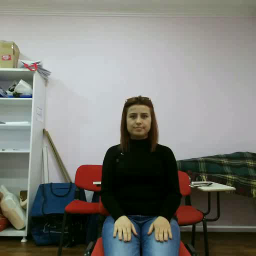

In [113]:
final_frame

In [17]:
print(history.history.keys())
# summarize history for accuracy



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [18]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: 'categorical_accuracy'

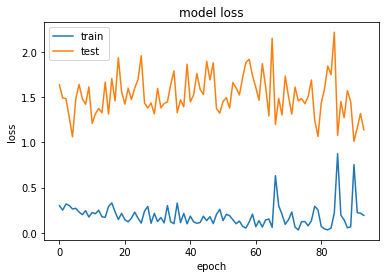

In [153]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
model.evaluate(train_X,train_Y)

2021-12-29 13:55:00.632707: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1834352640 exceeds 10% of free system memory.
2021-12-29 13:55:11.189614: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.71GiB (rounded to 1834352640)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2021-12-29 13:55:11.189691: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2021-12-29 13:55:11.189727: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 56, Chunks in use: 55. 14.0KiB allocated for chunks. 13.8KiB in use in bin. 804B client-requested in use in bin.
2021-12-29 13:55:11.189749: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 2,

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

1.190120: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (268435456): 	Total Chunks: 2, Chunks in use: 1. 2.00GiB allocated for chunks. 1.71GiB in use in bin. 1.71GiB client-requested in use in bin.
2021-12-29 13:55:11.190139: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] Bin for 1.71GiB was 256.00MiB, Chunk State: 
2021-12-29 13:55:11.190168: I tensorflow/core/common_runtime/bfc_allocator.cc:1039]   Size: 298.62MiB | Requested Size: 45.00MiB | in_use: 0 | bin_num: 20, prev:   Size: 1.71GiB | Requested Size: 1.71GiB | in_use: 1 | bin_num: -1
2021-12-29 13:55:11.190183: I tensorflow/core/common_runtime/bfc_allocator.cc:1046] Next region of size 2147483648
2021-12-29 13:55:11.190202: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f1768000000 of size 1834352640 next 71
2021-12-29 13:55:11.190218: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] Free  at 7f17d5560000 of size 313131008 next 18446744073709551615
2021-12-29 13:55:11.190231: I t

# 5 - test in real time

In [113]:
from scipy import stats

colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num%3], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame


In [114]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if(not ret):
            break
#         frame = cv2.resize(frame, (512, 512))

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-20:]
        
        if len(sequence) == 20:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-2:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [60]:
cap.release()

In [61]:
cv2.destroyAllWindows()

# Conclusion 
there are a lot of problems realted to memory and gpu and the model is very slow in training
the loss doesn't get smaller
